In [1]:
# Step reward function: hprime=0.2, h=0.01
# Change the dataset before calculating posterior on quadratic fn

In [2]:
import json
import sys
sys.path.append('../simulated_fqi/')
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import torch
import random
import shap
import configargparse
import torch
import torch.optim as optim
import scipy
from environments import Gridworld
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
from train import fqi
import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import LinearRegression
from irl_gridworld import find_feature_expectations, plot_reward, norm, find_valid_actions, generate_rollout, generate_policy_rollout, runLinearFQI, l2_norm
from multiprocessing import Pool
from matplotlib.colors import LogNorm, Normalize
from sklearn.preprocessing import normalize
plt.rcParams.update({'font.size': 22})

In [14]:
def generate_policy_rollout_nonlinear(group=0, target_state=None):
    rollout = []
    episode_cost = 0
    obs = [np.random.choice(4), np.random.choice(4)]
    done = False
    info = {"time_limit": False}
    time_limit = 15
    it = 0
    while it < time_limit:
        valid_actions, action_pos_dict = find_valid_actions(obs)
        max_reward = None
        max_a = None

        curr_rewards = np.zeros(len(valid_actions))
        for ii, a in enumerate(valid_actions):
            nxt_agent_state = (obs[0] + action_pos_dict[a][0], obs[1] + action_pos_dict[a][1])
            if nxt_agent_state[0] == target_state[0] and nxt_agent_state[1] == target_state[1]:
                reward = 1.0
            else:
                reward = 0.0
            curr_rewards[ii] = reward #+ np.random.normal(scale=0.01)

        # Choose best action, randomly breaking ties
        best_action_idx = np.random.choice(np.flatnonzero(curr_rewards == curr_rewards.max()))
        max_reward = curr_rewards[best_action_idx]
        action = action_pos_dict[valid_actions[best_action_idx]]
        next_obs = (obs[0] + action[0], obs[1] + action[1])
        cost = max_reward
        done = False
        if next_obs[0] == target_state[0] and next_obs[1] == target_state[1]:
            done = True
        rollout.append((obs, action, cost, next_obs, done, group))
        obs = next_obs
        it += 1
        if done:
            rollout.append((target_state, [0, 0], 1.0, True, group))
            rollout.append((target_state, [0, 0], 1.0, True, group))
            rollout.append((target_state, [0, 0], 1.0, True, group))
            rollout.append((target_state, [0, 0], 1.0, True, group))
            break
    return rollout

def runNonlinearFQI(behavior=True, group=0, target_state=None, init_experience=100, n=4):
    
    train_env = Gridworld(group=group, target_state=target_state, n=n, nonlinear=True)
    eval_env = Gridworld(group=group, target_state=target_state, n=n, nonlinear=True)

    rollouts = []
    if init_experience > 0:
        for _ in range(init_experience):
            rollout, episode_cost = train_env.generate_rollout(None, render=False, group=group, random_start=True)
            rollouts.extend(rollout)
    all_rollouts = rollouts.copy()

    if not behavior:
        # We don't even use the regression network to predict reward. The rollouts are literally just behavior
        reg = LinearRegression()
        gamma = 0.95
        state_b, action_b, cost_b, next_state_b, done_b, group_b = zip(*all_rollouts)
        done_b = torch.FloatTensor(done_b)
        cost_b = torch.FloatTensor(cost_b)
        reg = LinearRegression().fit(next_state_b, cost_b)
        rollouts = []
        if init_experience > 0:
            for _ in range(int(init_experience/2)):
                rollout = generate_rollout(reg, group=group, target_state=target_state, random_start=False)
                rollouts.extend(rollout)
        policy_rollouts = rollouts
    else:
        rollouts = []
        if init_experience > 0:
            for _ in range(init_experience):
                rollout = generate_policy_rollout_nonlinear(group=group, target_state=target_state)
                rollouts.extend(rollout)
            policy_rollouts=rollouts
    return policy_rollouts

def runParametricFQI(behavior=True, group=0, reward_params=[3, -3, 5], init_experience=100, n=4, target_state=[3, 0]):
    train_env = Gridworld(group=group, target_state=target_state, n=n, parametric=True, reward_params=reward_params)
    eval_env = Gridworld(group=group, target_state=target_state, n=n, parametric=True, reward_params=reward_params)

    rollouts = []
    if init_experience > 0:
        for _ in range(init_experience):
            rollout, episode_cost = train_env.generate_rollout(None, render=False, group=group, random_start=True)
            rollouts.extend(rollout)
    all_rollouts = rollouts.copy()

    if not behavior:
        # We don't even use the regression network to predict reward. The rollouts are literally just behavior
        reg = LinearRegression()
        gamma = 0.95
        state_b, action_b, cost_b, next_state_b, done_b, group_b = zip(*all_rollouts)
        done_b = torch.FloatTensor(done_b)
        cost_b = torch.FloatTensor(cost_b)
        reg = LinearRegression().fit(next_state_b, cost_b)
        rollouts = []
        if init_experience > 0:
            for _ in range(int(init_experience/2)):
                rollout = generate_rollout(reg, group=group, target_state=target_state, random_start=False)
                rollouts.extend(rollout)
        policy_rollouts = rollouts
    else:
        rollouts = []
        if init_experience > 0:
            for _ in range(init_experience):
                rollout = generate_policy_rollout_nonlinear(group=group, target_state=target_state)
                rollouts.extend(rollout)
            policy_rollouts=rollouts
    return policy_rollouts

def plot_reward(n=4, title='Reward target = [3, 0]', target_state=None):
    reward_matrix = np.zeros((n, n))
    positions = [i for i in range(n)]
    for i, x in enumerate(range(n)):
        for j, y in enumerate(range(n)):
            if [x, y] == target_state:
                reward = 1.0
            else:
                reward = 0.0
            reward_matrix[j,i] = reward
    plt.figure(figsize=(5, 5))
    ax = sns.heatmap(reward_matrix, xticklabels=positions, yticklabels=positions)
    plt.xlabel("X")
    plt.ylabel("Y")
    ax.invert_yaxis()
#     plt.title(title)

def plot_reward_parametric(n=4, title="Reward = ", reward_params=None):
    reward_matrix = np.zeros((n, n))
    positions = [i for i in range(n)]
    for i, x in enumerate(range(n)):
        for j, y in enumerate(range(n)):
            reward = np.power(x, 2)*reward_params[0] + x*y*reward_params[1] + reward_params[2]
            reward_matrix[j,i] = reward
    plt.figure(figsize=(5, 5))
    reward_matrix /= np.max(np.abs(reward_matrix))
    ax = sns.heatmap(reward_matrix, xticklabels=positions, yticklabels=positions)
    plt.xlabel("X")
    plt.ylabel("Y")
    ax.invert_yaxis()
    title += " " + str(reward_params[0]) + "x^2 " + str(reward_params[1]) + "xy + " + str(reward_params[2])
    
    plt.title(title)
    
def generate_dataset_plot(dataset, target_state):
    xs = [b[0][0] for b in dataset]
    ys = [b[0][1] for b in dataset]
    
    heatmap_dataset = np.zeros((4, 4))
    for i, x_i in enumerate(xs):
        y_i = ys[i]
        heatmap_dataset[y_i, x_i] += 1
    
    heatmap_dataset /= np.max(np.abs(heatmap_dataset))
    x = np.arange(0, 4, 1)
    y = np.arange(0, 4, 1)
    
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(5)
    ax = sns.heatmap(heatmap_dataset)
    ax.invert_yaxis()
    ax.set_xticklabels(x, rotation=90)
    ax.set_yticklabels(y, rotation=360)
#     plt.title("Demonstration density")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    plt.close()
    return heatmap_dataset

def generate_observations(init_experience=5, n=4):
    target_states = []
    for i in range(15):
        target_states.append([np.random.choice(4), np.random.choice(4)])
    
    observations = []
    for r in target_states:
        behavior_opt = runNonlinearFQI(init_experience=init_experience, behavior=True, target_state=r, n=n)
        for sample in behavior_opt:
            s = (sample[0], sample[1], r)
            observations.append(s)
    return observations

def generate_observations_parametric(init_experience=5, n=4):
    params = []
    for i in range(15):
        params.append([np.random.choice(-3, 3), np.random.choice(-3, 3), np.random.choice(-3, 3)])
    
    observations = []
    for r in target_states:
        behavior_opt = runParametricFQI(init_experience=init_experience, behavior=True, target_state=r, n=n)
        for sample in behavior_opt:
            s = (sample[0], sample[1], r)
            observations.append(s)
    return observations

def distance_r(r, r_prime):
    h_prime = 0.2
    dist = scipy.spatial.distance.euclidean(r, r_prime)
    # Euclidean distance
    return np.exp(-(np.power(dist, 2)/(2*h_prime)))

def distance_points(p1, p2):
    h = 0.01
    # Removing the action part
    # Only looking at the euclidean distance between the points
    dist = scipy.spatial.distance.euclidean(p1[0], p2[0]) #+ scipy.spatial.distance.euclidean(p1[1], p2[1])
    return np.exp(-np.power(dist, 2)/(2*h))

def distance_rewards(ts, observations):
    sum_diff = 0
    for sample in observations:
        ts_j = sample[2]
        sum_diff += distance_r(ts, ts_j)
    return sum_diff

def conditional_dist(s_i, dataset, target_state):
    sum = 0
    dist_rewards = distance_rewards(target_state, dataset)
    sum_weights = 0
    count_p = 0
    for s_j in dataset:
        weight = distance_r(target_state, s_j[2]) / dist_rewards
        dist = distance_points(s_i, s_j)
        est = dist * weight 
        sum += est
    return sum

def estimate_expert_prior(target_state, behavior_opt, observations):
    post = 0
    dist_rewards = distance_rewards(target_state, observations)
    for s_i in behavior_opt:
        sum_si = 0
        for s_j in observations:
            # Distance between rewards
            weight = distance_r(target_state, s_j[2]) / dist_rewards
            likelihood = distance_points(s_i, s_j) * weight
            sum_si += likelihood
        if sum_si == 0:
            post += np.log(0.000000000001)
        else:
            post += np.log(sum_si)
    return post

def heatmap_dataset_conditional_density_posterior(target_state, reward_params=None, parametric=False, plot=True):
    # n observations
    observations = generate_observations(init_experience=10, n=4)
    # m expert observations
    if parametric:
        behavior_opt = runParametricFQI(init_experience=10, behavior=True, reward_params=reward_params)
    else:
        behavior_opt = runNonlinearFQI(init_experience=10, behavior=True, target_state=target_state, n=4)
        
    if plot:
        heatmap_dataset = generate_dataset_plot(behavior_opt, target_state)

        x = np.arange(0, 4, 1)
        y = np.arange(0, 4, 1)
        xx, yy = np.meshgrid(x, y, sparse=True)
        heatmap_conditional = np.zeros((4, 4))
        action_pos_dict = {1: [-1, 0], 2: [1, 0], 3: [0, -1], 4: [0, 1]}
        xs = []
        ys = []
        zs = []
        conditional_est = []
        for a in [1, 2, 3, 4]:
            action = action_pos_dict[a]
            for kk, i in enumerate(tqdm.tqdm(range(xx.shape[1]))):
                for j in range(yy.shape[0]):
                    # Evaluate the posterior at this reward parameter
                    state = ([xx[0][i], yy[j][0]], action)
                    c_est = conditional_dist(state, observations, target_state)
                    conditional_est.append(c_est)
                    heatmap_conditional[j, i] += c_est
        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(5)
        ax = sns.heatmap(heatmap_conditional)
#         plt.title("Conditional density for target_state=" + str(target_state))
        ax.invert_yaxis()
        ax.set_xticklabels(x, rotation=90)
        ax.set_yticklabels(y, rotation=360)
        plt.show()
        plt.close()
        
        x = np.arange(0, 4, 1)
        x = np.around(x, decimals=1)
        y = np.arange(0, 4, 1)
        y = np.around(y, decimals=1)
        xx, yy = np.meshgrid(x, y, sparse=True)
        heatmap_posterior = np.zeros((4, 4))
        for kk, i in enumerate(tqdm.tqdm(range(xx.shape[1]))):
            for j in range(yy.shape[0]):
                # Evaluate the posterior at this reward parameter
                ts = [xx[0][i], yy[j][0]]
                post = estimate_expert_prior(ts, behavior_opt, observations)
                heatmap_posterior[j, i] = post
        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(5)
        ax = sns.heatmap(heatmap_posterior)
        ax.invert_yaxis()
        plt.xlabel("X")
        plt.ylabel("Y")
#         plt.title("Expert posterior, target_state=" + str(target_state))
        ax.set_xticklabels(x, rotation=90)
        ax.set_yticklabels(y, rotation=360)
        plt.show()
        plt.close()
    else:
        x = np.arange(0, 4, 1)
        x = np.around(x, decimals=1)
        y = np.arange(0, 4, 1)
        y = np.around(y, decimals=1)
        xx, yy = np.meshgrid(x, y, sparse=True)
        heatmap_posterior = np.zeros((4, 4))
        for kk, i in enumerate(tqdm.tqdm(range(xx.shape[1]))):
            for j in range(yy.shape[0]):
                # Evaluate the posterior at this reward parameter (target state)
                ts = [xx[0][i], yy[j][0]]
                post = estimate_expert_prior(ts, behavior_opt, observations)
                heatmap_posterior[j, i] = post
        heatmap_posterior /= np.max(np.abs(heatmap_posterior))
    return heatmap_posterior

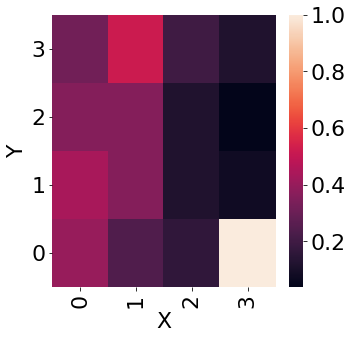

 75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]


KeyboardInterrupt: 

In [16]:
heatmap_dataset_conditional_density_posterior(target_state=[3, 0])

100%|██████████| 4/4 [01:42<00:00, 25.66s/it]


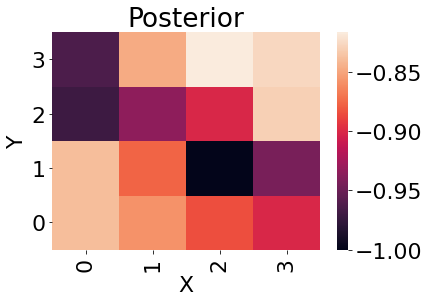

In [10]:
hmap1 = heatmap_dataset_conditional_density_posterior(target_state=[3, 0], plot=False)
ax = sns.heatmap(hmap1)
ax.invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Posterior")
ax.set_xticklabels([0, 1, 2, 3], rotation=90)
ax.set_yticklabels([0, 1, 2, 3], rotation=360)
plt.show()
plt.close()

100%|██████████| 4/4 [01:36<00:00, 24.17s/it]


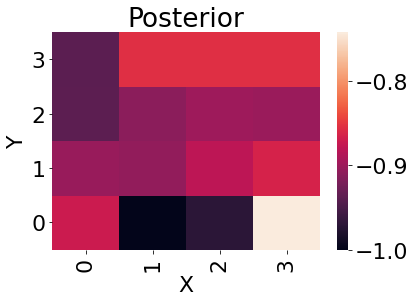

In [11]:
hmap2 = heatmap_dataset_conditional_density_posterior(target_state=[3, 0], plot=False)
ax = sns.heatmap(hmap2)
ax.invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Posterior")
ax.set_xticklabels([0, 1, 2, 3], rotation=90)
ax.set_yticklabels([0, 1, 2, 3], rotation=360)
plt.show()
plt.close()

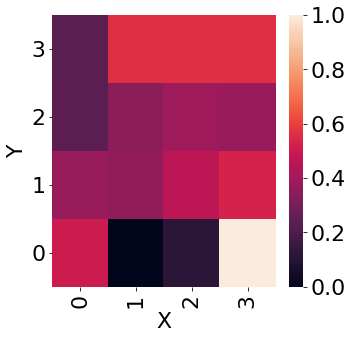

In [13]:
hmap2 = (hmap2 - np.min(hmap2))/np.ptp(hmap2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(5)
ax = sns.heatmap(hmap2)
ax.invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
ax.set_xticklabels([0, 1, 2, 3], rotation=90)
ax.set_yticklabels([0, 1, 2, 3], rotation=360)
plt.show()
plt.close()

In [ ]:
hmap3 = heatmap_dataset_conditional_density_posterior(target_state=[3, 0], plot=False)
ax = sns.heatmap(hmap3)
ax.invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Posterior")
ax.set_xticklabels([0, 1, 2, 3], rotation=90)
ax.set_yticklabels([0, 1, 2, 3], rotation=360)
plt.show()
plt.close()

In [ ]:
hmap4 = heatmap_dataset_conditional_density_posterior(target_state=[3, 0], plot=False)
sns.heatmap(hmap)
ax = sns.heatmap(hmap)
ax.invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Posterior")
ax.set_xticklabels([0, 1, 2, 3], rotation=90)
ax.set_yticklabels([0, 1, 2, 3], rotation=360)
plt.show()
plt.close()

In [ ]:
all_hmaps = np.zeros((1, 4, 4))
for i in range(5):
    hmap_posterior = heatmap_dataset_conditional_density_posterior(target_state=[3, 0], plot=False)
    all_hmaps = np.append(all_hmaps, np.asarray([hmap_posterior]), axis=0)

In [ ]:
mean_hmap = np.mean(all_hmaps[1:], axis=0)
mean_hmap = (mean_hmap - np.min(mean_hmap))/np.ptp(mean_hmap)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(5)
ax = sns.heatmap(mean_hmap)
ax.invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Reward Mean Scaled")
ax.set_xticklabels([0, 1, 2, 3], rotation=90)
ax.set_yticklabels([0, 1, 2, 3], rotation=360)
plt.show()
plt.close()

In [ ]:
sd_hmap = np.std(all_hmaps[1:], axis=0)
sd_hmap /= np.max(np.abs(sd_hmap))
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(5)
ax = sns.heatmap(sd_hmap)
ax.invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Reward SD Scaled")
ax.set_xticklabels([0, 1, 2, 3], rotation=90)
ax.set_yticklabels([0, 1, 2, 3], rotation=360)
plt.show()
plt.close()

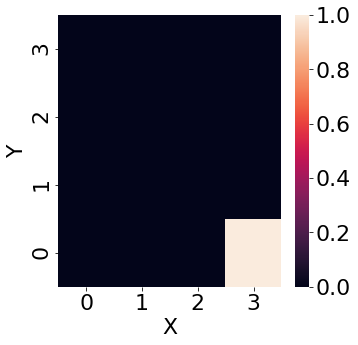

In [8]:
plot_reward(target_state=[3, 0])